In [144]:
!unzip 'Machine Translation.zip'

unzip:  cannot find or open Machine Translation.zip, Machine Translation.zip.zip or Machine Translation.zip.ZIP.


In [145]:
cd 'Machine Translation'

[Errno 2] No such file or directory: 'Machine Translation'
/content/Machine Translation


In [146]:
!pip install faker

**CREATING A DATASET FOR MACHINE TRANSLATION**



In [0]:
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

fake = Faker()
# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

In [0]:
"""
    Loads some fake dates 
   :returns: tuple containing human readable string, machine readable string, and date object
"""

def load_date():
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [149]:
load_date()

('monday september 18 2017', '2017-09-18', datetime.date(2017, 9, 18))

In [0]:
"""
    Loads a dataset with m examples and vocabularies
    m: the number of examples to generate
"""
def load_dataset(m):
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):   # tqdm just generates a progress bar
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))   # tuple('string') = ('s', 't,', 'r', 'i', 'n', 'g')
            machine_vocab.update(tuple(m))  
         
    print(human_vocab)
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],  #sorted will create a list of the set in sorted order
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [151]:
load_dataset(5)

100%|██████████| 5/5 [00:00<00:00, 3309.90it/s]

{'9', 'g', '6', '2', 'h', 't', 'c', 'n', 'm', 'p', '5', '1', 's', 'a', 'b', 'l', 'i', 'e', '3', '7', 'd', 'r', 'u', ' ', '0', 'y', 'o'}


([('sunday october 25 1992', '1992-10-25'),
  ('20 03 07', '2007-03-20'),
  ('sunday may 9 1976', '1976-05-09'),
  ('tuesday august 22 1972', '1972-08-22'),
  ('thursday april 12 1973', '1973-04-12')],
 {' ': 0,
  '0': 1,
  '1': 2,
  '2': 3,
  '3': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '9': 8,
  '<pad>': 28,
  '<unk>': 27,
  'a': 9,
  'b': 10,
  'c': 11,
  'd': 12,
  'e': 13,
  'g': 14,
  'h': 15,
  'i': 16,
  'l': 17,
  'm': 18,
  'n': 19,
  'o': 20,
  'p': 21,
  'r': 22,
  's': 23,
  't': 24,
  'u': 25,
  'y': 26},
 {'-': 0,
  '0': 1,
  '1': 2,
  '2': 3,
  '3': 4,
  '4': 5,
  '5': 6,
  '6': 7,
  '7': 8,
  '8': 9,
  '9': 10},
 {0: '-',
  1: '0',
  2: '1',
  3: '2',
  4: '3',
  5: '4',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9'})

In [152]:
# creating a dataset of 10000 training entries
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 17124.84it/s]

{'9', '.', 'g', 'j', '6', '2', 'h', 't', 'c', 'n', 'm', 'p', '5', '1', 'f', 's', 'a', 'b', '/', 'l', 'i', 'e', 'v', 'w', '3', '7', 'd', 'r', 'u', ' ', '4', '0', '8', 'y', 'o'}


In [153]:
dataset[:10]

[('2 jan 1971', '1971-01-02'),
 ('18 aug 1980', '1980-08-18'),
 ('december 11 1982', '1982-12-11'),
 ('saturday july 28 2007', '2007-07-28'),
 ('wednesday march 3 1999', '1999-03-03'),
 ('wednesday september 26 1979', '1979-09-26'),
 ('18 march 1976', '1976-03-18'),
 ('30 04 77', '1977-04-30'),
 ('sunday december 25 1988', '1988-12-25'),
 ('saturday april 20 1996', '1996-04-20')]

**PRE-PROCESSING DATA, MAPPING STRING TO LIST OF INTEGERS**

In [0]:
import numpy as np
from keras.utils import to_categorical

def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    #print(rep)
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep

In [0]:
def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l

In [0]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = np.array([string_to_int(t, Ty, machine_vocab) for t in Y])
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, Y, Xoh, Yoh

In [157]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


**BUILDING THE ATTENTION MECHANISM TO CALCULATE CONTEXT OF EACH TIME-STEP OF PRE-ATTENTION BI-LSTM**

In [0]:
from keras.layers import RepeatVector, Dense, Activation, Concatenate, Dense, Dot, LSTM
import keras.backend as K

In [0]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [0]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = 'tanh')
densor2 = Dense(1, activation = 'relu')
activator = Activation(softmax, name = 'attention_weights_alpha')  # Custom softmax to calculate about axis = 1
dotor = Dot(axes = 1)

In [0]:
#Calculates context value for one time-step

def one_step_attention(a, s_prev):
  """Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
  """
  
  s_prev = repeator(s_prev)
  concat = concatenator([a, s_prev])
  e = densor1(concat)
  energies = densor2(e)
  alphas = activator(energies)
  context = dotor([alphas, a])
  
  return context  # shape of context is (m, 2*n_a)

**DEFINING LAYERS OF POST-LSTM MODEL**



In [0]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation = 'softmax')

**MAKING THE MODEL**

In [0]:
from keras.layers import Bidirectional, Input
from keras.models import Model

def model(Tx, Ty, n_a, n_s, human_vocab, machine_vocab):
  X = Input((Tx, human_vocab))
  s0 = Input((n_s,), name = 's0')
  c0 = Input((n_s,), name = 'c0')
  s = s0
  c = c0
  
  outputs = []
  
  a = Bidirectional(LSTM(n_a, return_sequences = True))(X)
  
  for t in range(Ty):
    context = one_step_attention(a, s)
    s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
    out = output_layer(s)
    outputs.append(out)
    
  model = Model(inputs = [X, s0, c0], outputs = outputs)
  
  return model

In [0]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [165]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 30, 64)       17920       input_11[0][0]                   
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_13[0][0]                    
          

In [0]:
from keras.optimizers import Adam
opt = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
target = list(Yoh.swapaxes(0,1))

In [168]:
model.fit([Xoh, s0, c0], target, epochs = 100, batch_size = 128)

Epoch 1/100
10000/10000 [==============================] - 28s 3ms/step - loss: 18.7905 - dense_16_loss: 2.6185 - dense_16_acc: 0.2969 - dense_16_acc_1: 0.5880 - dense_16_acc_2: 0.2545 - dense_16_acc_3: 0.0549 - dense_16_acc_4: 0.9238 - dense_16_acc_5: 0.2063 - dense_16_acc_6: 0.0144 - dense_16_acc_7: 0.9213 - dense_16_acc_8: 0.2045 - dense_16_acc_9: 0.0934
Epoch 2/100
10000/10000 [==============================] - 15s 2ms/step - loss: 10.4376 - dense_16_loss: 2.2660 - dense_16_acc: 0.9406 - dense_16_acc_1: 0.9507 - dense_16_acc_2: 0.4632 - dense_16_acc_3: 0.1498 - dense_16_acc_4: 1.0000 - dense_16_acc_5: 0.7929 - dense_16_acc_6: 0.2010 - dense_16_acc_7: 1.0000 - dense_16_acc_8: 0.4459 - dense_16_acc_9: 0.1457
Epoch 3/100
10000/10000 [==============================] - 15s 2ms/step - loss: 8.2700 - dense_16_loss: 2.0664 - dense_16_acc: 0.9730 - dense_16_acc_1: 0.9730 - dense_16_acc_2: 0.6186 - dense_16_acc_3: 0.2555 - dense_16_acc_4: 1.0000 - dense_16_acc_5: 0.9065 - dense_16_acc_6: 0.4

In [0]:
model.save_weights('weights.h5')

**TESTING THE MODEL WITH EXAMPLES**

In [170]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
  source = string_to_int(example, Tx, human_vocab)
  source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).reshape((1, Tx, len(human_vocab)))
  prediction = model.predict([source, np.zeros((1, n_s)), np.zeros((1, n_s))])
  prediction = np.array(np.argmax(prediction, axis = -1))
  output = [inv_machine_vocab[int(i)] for i in prediction]
  
  print('source: ', example)
  print('output: ', ''.join(output))

source:  3 May 1979
output:  1979-05-03
source:  5 April 09
output:  2009-04-05
source:  21th of August 2016
output:  2016-08-00
source:  Tue 10 Jul 2007
output:  2007-07-10
source:  Saturday May 9 2018
output:  2018-05-09
source:  March 3 2001
output:  2001-03-03
source:  March 3rd 2001
output:  2001-03-00
source:  1 March 2001
output:  2001-03-01


**VISUALISING ATTENTION WEIGHTS ALPHAS**

In [0]:
def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

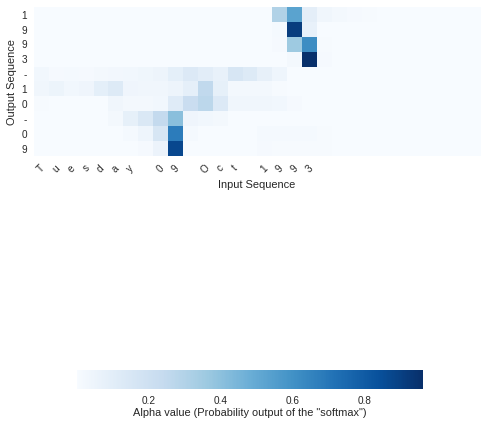

In [173]:
import matplotlib.pyplot as plt
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)